In [73]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

from scipy import interp
import math
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=50
pl.style.use('ggplot')

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

In [11]:
v_train=pd.read_csv('titanic_train.csv')
v_test=pd.read_csv('titanic_test.csv')

In [9]:
display(v_train.sample(3))

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
21,1030,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,NaN,NaN,0
134,960,3,"Lemberopolous, Mr. Peter L",male,34.5,0,0,2683,6.4375,NaN,C,NaN,196.0,NaN,0
256,498,2,"McCrae, Mr. Arthur Gordon",male,32.0,0,0,237216,13.5000,NaN,S,NaN,209.0,"Sydney, Australia",0


In [12]:
v_test.head(3)

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,295,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,C,B,NaN,"Haverford, PA"
1,1150,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S,NaN,NaN,NaN
2,89,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S,NaN,NaN,"Montreal, PQ"


In [13]:
v_train.drop(columns=['passenger_id'],inplace=True)
v_test.drop(columns=['passenger_id'],inplace=True)

In [21]:
v_merged=pd.concat([v_train,v_test],sort=False).reset_index(drop=True)

In [22]:
v_merged.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1.0
1,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0.0
2,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0.0
3,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1.0
4,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0.0


In [23]:
v_merged.shape

(1309, 14)

In [24]:
v_merged.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'survived'],
      dtype='object')

In [25]:
v_merged.drop(columns=['boat','body','home.dest'],inplace=True)
v_merged.shape

(1309, 11)

In [26]:
v_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float64
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  850 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


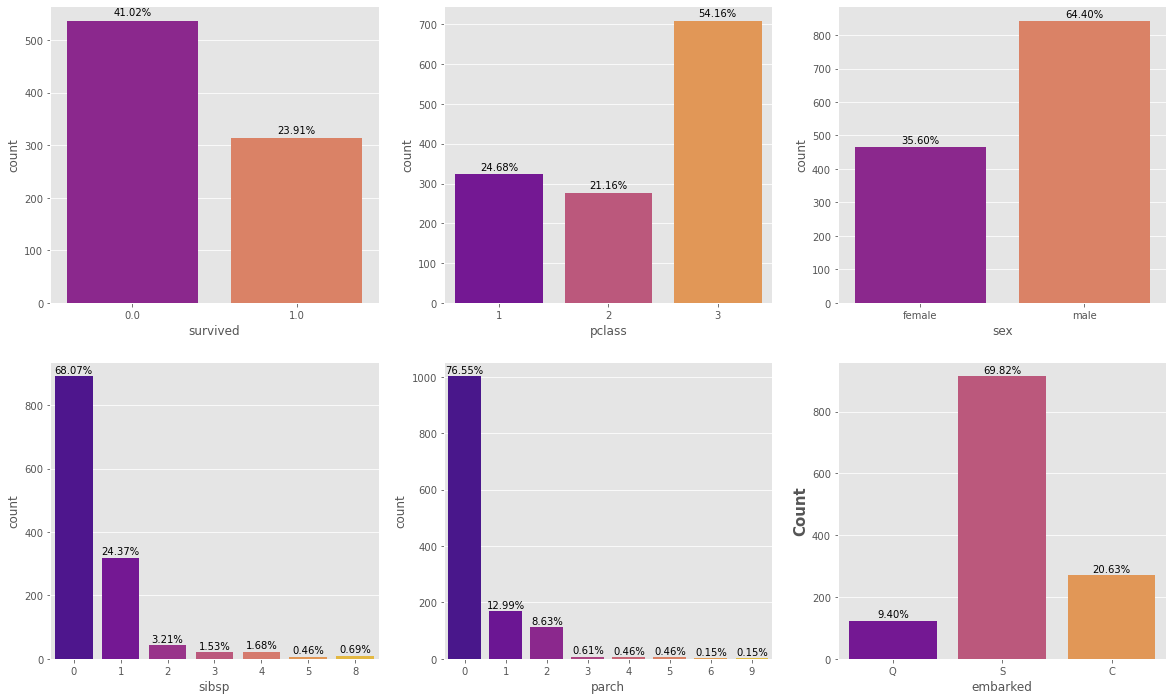

In [52]:
cats = ['survived', 'pclass', 'sex', 'sibsp', 'parch', 'embarked']

def plot_frequency(cats):
    fig,axes=pl.subplots(math.ceil(len(cats)/3),3,figsize=(20,12))
    axes=axes.flatten()
    for ax,cat in zip(axes,cats):
        if cat=='Survived':
            total=float(len(v_train[cat]))
        else:
            total=float(len(v_merged[cat]))
        sns.countplot(v_merged[cat],palette='plasma',ax=ax)
    
        for p in ax.patches:
            height=p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                   height+10,
                   '{:1.2f}%'.format((height/total)*100),
                   ha='center')
    pl.ylabel('Count',fontsize=15,weight='bold')
plot_frequency(cats)

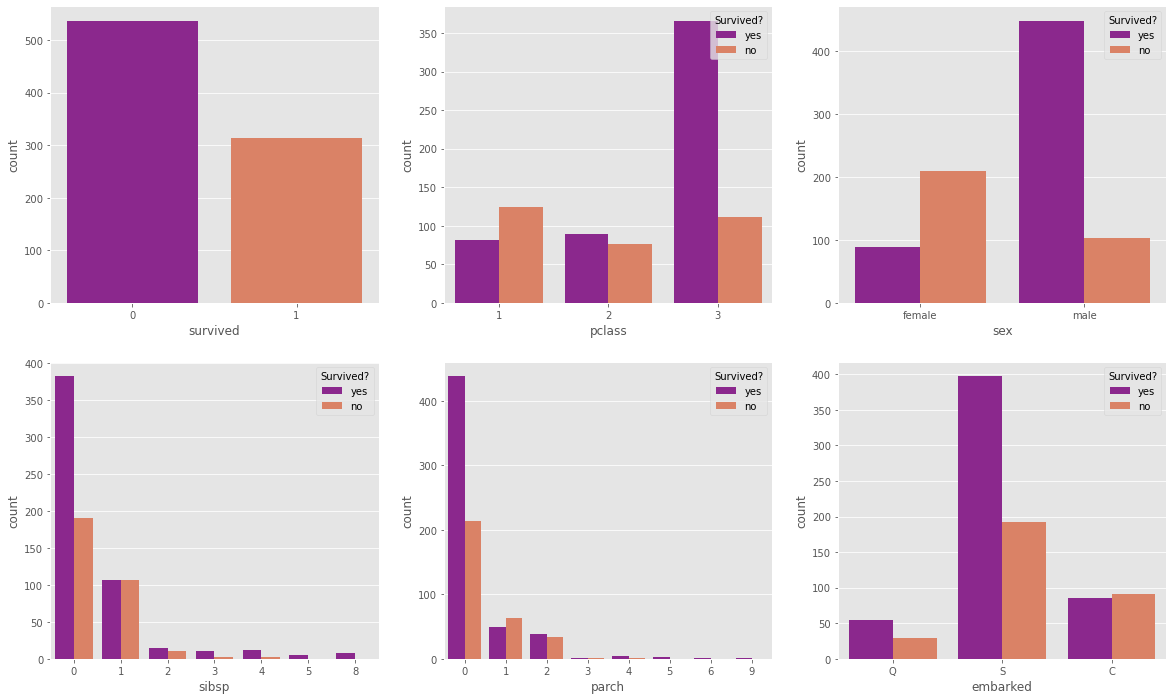

In [71]:
def plot_survival(cats,data):
    fig,axes=pl.subplots(math.ceil(len(cats)/3),3,figsize=(20,12))
    axes=axes.flatten()
    for ax,cat in zip(axes,cats):
        if cat=='survived':
            total=float(len(v_train[cat]))
            sns.countplot(v_train[cat],palette='plasma',ax=ax)
        else:
            total=float(len(v_merged[cat]))
            sns.countplot(x=cat,data=data,ax=ax,hue='survived',palette='plasma')
            ax.legend(title='Survived?',
                     loc='upper right',
                     labels=['yes','no'])

#         for p in ax.patches:
#             height=p.get_height()
#             ax.text(p.get_x()+p.get_width()/2.,
#                    height+10,
#                    '{:1.2f}%'.format((height/total)*100),
#                    ha='center')
            
plot_survival(cats,v_train)

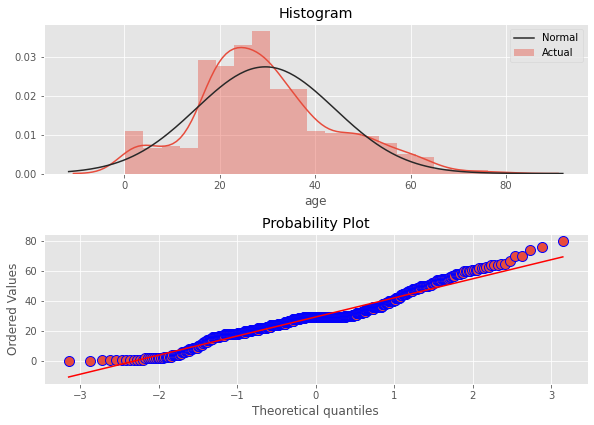

In [95]:
def plot_3dchart(df,feature):
    fig=pl.figure(constrained_layout=True, figsize=(12,8))
    grid=gridspec.GridSpec(ncols=3,nrows=3,figure=fig)
    
    ax1=fig.add_subplot(grid[0,:2])
    ax1.set_title("Histogram")
    sns.distplot(df[feature],hist=True,kde=True,fit=norm,ax=ax1,
                 color='#e74c3c')
    ax1.legend(['Normal','Actual'])
    
    ax2=fig.add_subplot(grid[1,:2])
    ax2.set_title("Probablity port")
    stats.probplot(df[feature].fillna(np.mean(df[feature])),plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(10)
    
plot_3dchart(v_train,'age')